In [1]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.applications.vgg16 import VGG16
from keras.applications import vgg16, vgg19, inception_v3, xception, resnet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.optimizers import SGD
from keras import regularizers
import keras.backend as K

import pandas as pd
from shutil import copyfile

from keras.utils import plot_model
import code  # https://www.digitalocean.com/community/tutorials/how-to-debug-python-with-an-interactive-console
import datetime


Using TensorFlow backend.


In [2]:
#default for inceptionv3
ARCHITECTURE = "inceptionv3"
# IM_WIDTH, IM_HEIGHT = 299, 299
NB_EPOCHS = 10
BAT_SIZE = 128   
LEARNING_RATE = 1e-4
# FC_SIZE = 1024
# NB_LAYERS_TO_FREEZE = 172

In [3]:
def mean_L1_distance(y_true, y_pred):
    return K.mean(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)

def min_L1_distance(y_true, y_pred):
    return K.min(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)

def max_L1_distance(y_true, y_pred):
    return K.max(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)

def std_L1_distance(y_true, y_pred):
    return K.std(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)

In [4]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [5]:
def setup_to_transfer_learn(model, base_model, optimizer_in, loss_in, learning_rate  ):
    """Freeze all layers and compile the model"""  # Transfer learning: freeze all but the penultimate layer and re-train the last Dense layer
    print('Number of trainable weight tensors '
      'before freezing the conv base:', len(model.trainable_weights))
    
    for layer in base_model.layers:
        layer.trainable = False
        
    print('Number of trainable weight tensors '
      'after freezing the conv base:', len(model.trainable_weights))
    
    if optimizer_in == 'rmsprop':
        optimizer_tf = optimizers.RMSprop(lr = learning_rate)
    elif optimizer_in == 'adam':
        optimizer_tf = optimizers.Adam(lr = learning_rate)
    elif optimizer_in == 'sgd':
        optimizer_tf = optimizers.SGD(lr = learning_rate, momentum=9.0, nesterov=True)
    elif optimizer_in == 'adagrad':
        optimizer_tf = optimizers.Adagrad(lr = learning_rate)


    model.compile(optimizer = optimizer_tf,
                  loss = loss_in,
                  metrics=['acc', 'top_k_categorical_accuracy', mean_L1_distance, min_L1_distance, max_L1_distance])


In [6]:
def add_new_last_layer(base_model, nb_classes, FC_SIZE, regularizer, reg_rate):
    """Add last layer to the convnet

    Args:
      base_model: keras model excluding top
      nb_classes: # of classes    #passing in 104 from Input, but does this need to be 1000 since image net used that ( or actually number of classes found in train set)?

    Returns:
      new keras model with last layer
    """
    inlayer = base_model.input
    x = base_model.output

    # code.interact(local=locals())
    # print("current output Lastlayer x.shape: ")
    # print(x)				   #Tensor("mixed10/concat:0", shape=(?, ?, ?, 2048), dtype=float32)
    # print(x.shape)			   #(?, ?, ?, 2048)

    x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling2D converts the MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = Dense(FC_SIZE, activation='relu')(x)  # new FC layer, random init  a fully-connected Dense layer of size 1024
    # print("after pooling, dense Lastlayer x.shape: ")
    # print(x)				   #Tensor("dense_1/Relu:0", shape=(?, 1024), dtype=float32)
    # print(x.shape)                           #(?, 1024)

    # new softmax layer on the output to squeeze the values between [0,1]
    if regularizer == "none":
        predictions = Dense(nb_classes, activation='softmax')(x)
    else:
        if regularizer == "L1":
            print("using L1 regularization")
            #see https://keras.io/regularizers/
            predictions = Dense(nb_classes, activation='softmax', kernel_regularizer=regularizers.l1(reg_rate) )(x)
        
    # print("predictions.shape: ")
    print("PREDICTIONS need to be in [0,1].  nb_classes: ", nb_classes, " should be the size of your last layer")
    print(predictions)
    print(predictions.shape)  # (?, 0)

    model = Model(inputs=base_model.input,
                  outputs=predictions)  # UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
    # fixed via:  https://github.com/fchollet/keras/issues/7602  , change input= to inputs= , output=  to outputs=
    return model


In [7]:
def setup_to_finetune(model, LAYER_FROM_FREEZE, NB_LAYERS_TO_FREEZE, optimizer_in, loss_in, learning_rate):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.  #Fine-tuning: un-freeze the lower convolutional layers and retrain more layers

    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

    Args:
      model: keras model
    """
    
    print('Number of trainable weight tensors '
      'before starting the fine-tuning step:', len(model.trainable_weights))

    # Feature to unfreeze part of network from LAYER_FROM_FREEZE to the end
    if(LAYER_FROM_FREEZE != ''):
        model.trainable = True

        set_trainable = False

        for layer in model.layers:
            if layer.name == LAYER_FROM_FREEZE:
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

    else:
        for layer in model.layers[:NB_LAYERS_TO_FREEZE]:
            layer.trainable = False
        for layer in model.layers[NB_LAYERS_TO_FREEZE:]:
            layer.trainable = True
        
    print('Number of trainable weight tensors '
      'during the fine-tuning step:', len(model.trainable_weights))

    if optimizer_in == 'rmsprop':
        optimizer_tf = optimizers.RMSprop(lr = learning_rate/10)
    elif optimizer_in == 'adam':
        optimizer_tf = optimizers.Adam(lr = learning_rate/10)
    elif optimizer_in == 'sgd':
        optimizer_tf = optimizers.SGD(lr = learning_rate/10, momentum=9.0, nesterov=True)
    elif optimizer_in == 'adagrad':
        optimizer_tf = optimizers.Adagrad(lr = learning_rate/10)
      
    # We should use lower learning rate when fine-tuning. learning_rate /10 is a good start.
    model.compile(optimizer=optimizer_tf, loss=loss_in,
                  metrics=['acc', 'top_k_categorical_accuracy', mean_L1_distance, min_L1_distance, max_L1_distance])


In [8]:
def train(args):

    """Use transfer learning and fine-tuning to train a network on a new dataset"""

    # 0. CREATE EXPECTED FOLDER STRUCTURE
    # take yearbook_train.csv and generate new training folder which makes folders for each year present (treating women/men as same) and copies the files over to them!
    if os.path.isdir(args.data_dir + "/" + args.input_dir + "_" + args.model_name) == False:
        create_folder_with_classes(args.data_dir, args.data_dir + "/" + args.input_dir,
                                   args.input_dir + "_" + args.model_name, args.data_dir + "/" + args.train_file)

    # take yearbook_valid.csv and generate new validation folder which leaves F/  M/  but within each makes folders for each year present and copies the files over to them!
    if os.path.isdir(args.data_dir + "/" + args.valid_dir + "_" + args.model_name) == False:
        create_folder_with_classes(args.data_dir, args.data_dir + "/" + args.valid_dir,
                                   args.valid_dir + "_" + args.model_name, args.data_dir + "/" + args.valid_file)

    nb_train_samples = get_nb_files(args.data_dir + "/" + args.input_dir + "_" + args.model_name)  # 22840
    print("Looking in ", args.data_dir + "/" + args.input_dir + "_" + args.model_name + "/*")
    nb_classes = len(glob.glob(
        args.data_dir + "/" + args.input_dir + "_" + args.model_name + "/*"))  # 104              #1905 - 2013, you would expect 109, but there is no 1907, 1917, 1918, 1920, 1921
    nb_val_samples = get_nb_files(args.data_dir + "/" + args.valid_dir + "_" + args.model_name)  # 5009
    nb_epoch = int(args.nb_epoch)
    batch_size = int(args.batch_size)

    # for now need to force classes of validation to be same of train somehow
    response_classes = ['1905', '1906', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1919',
                        '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933',
                        '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945',
                        '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
                        '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
                        '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
                        '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
                        '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
                        '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']

    if args.input_dir == "train_sub":
        results = ['1930','1940','1950','1960','1970','1980','1990','2000']

    print("nb_train_samples: ", nb_train_samples)
    print("nb_classes: ", nb_classes)
    print("nb_val_samples: ", nb_val_samples)
    print("nb_epoch: ", nb_epoch)
    print("batch_size: ", batch_size)

    # SET DEFAULTS BASED ON ARTCHITECTURE
    ARCHITECTURE = args.model_name
    if args.model_name == "inceptionv3":
        IM_WIDTH, IM_HEIGHT = 299, 299 
        FC_SIZE = 1024  # should this be 2048 as opposed to 1024.. give it a try
        LAYER_FROM_FREEZE = ''
        NB_LAYERS_TO_FREEZE = 172
        # setup model
        base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)  # include_top=False excludes final FC layer
        # print(base_model.summary())
        preprocess_input = inception_v3.preprocess_input

    if args.model_name == "VGG16":
        IM_WIDTH, IM_HEIGHT = 224, 224
        FC_SIZE = 256
        LAYER_FROM_FREEZE = 'block5_conv1'
        NB_LAYERS_TO_FREEZE = None
        # setup model
        base_model = vgg16.VGG16(weights='imagenet', include_top=False)  # include_top=False excludes final FC layer
        # print(base_model.summary())
        preprocess_input = vgg16.preprocess_input


    if args.model_name == "VGG19":
        IM_WIDTH, IM_HEIGHT = 224, 224
        FC_SIZE = 256
        LAYER_FROM_FREEZE = 'block5_conv1'
        NB_LAYERS_TO_FREEZE = None
        # setup model
        base_model = vgg19.VGG19(weights='imagenet', include_top=False)  # include_top=False excludes final FC layer
        # print(base_model.summary())
        preprocess_input = vgg19.preprocess_input


    if args.model_name == "Xception":
        IM_WIDTH, IM_HEIGHT = 299, 299
        FC_SIZE = 256
        LAYER_FROM_FREEZE = 'block11_sepconv1_act'
        NB_LAYERS_TO_FREEZE = None
        # setup model
        base_model = xception.Xception(weights='imagenet', include_top=False)  # include_top=False excludes final FC layer
        # print(base_model.summary())
        preprocess_input = xception.preprocess_input



    if args.model_name == "ResNet50":
        IM_WIDTH, IM_HEIGHT = 224, 224
        FC_SIZE = 1024
        LAYER_FROM_FREEZE = 'res4a_branch2a'
        NB_LAYERS_TO_FREEZE = None
        # setup model
        base_model = resnet50.ResNet50(weights='imagenet', include_top=False)  # include_top=False excludes final FC layer
        # print(base_model.summary())
        preprocess_input = resnet50.preprocess_input





    # 1. PREPROCESS THE IMAGES WE HAVE
    # data prep  #https://keras.io/preprocessing/image/
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # test_datagen = ImageDataGenerator(
    #     preprocessing_function=preprocess_input,
    #     rotation_range=30,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True
    # )

    # Amin: I don't think the validation set shoud be augmented
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
    )

    # flow_from_directory(directory): Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.
    # Arguments:
    # - directory: path to the target directory.
    #   It should contain one subdirectory per class. Any PNG, JPG, BMP or PPM images inside each of the subdirectories directory tree will be included in the generator.
    # - target_size: tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.

    # 2. Go through Training data and Resize/Batch   , same with Valid data
    train_generator = train_datagen.flow_from_directory(
        args.data_dir + "/" + args.input_dir + "_" + args.model_name,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical',
        classes=response_classes
    )

    # label_to_class = train_generator.class_indices
    # class_to_label= {y: x for x, y in label_to_class.items()}
    # print(class_to_label)


    validation_generator = test_datagen.flow_from_directory(
        args.data_dir + "/" + args.valid_dir + "_" + args.model_name,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=batch_size,
        class_mode= 'categorical',
        classes=response_classes
    )


   

    model = add_new_last_layer(base_model, nb_classes, FC_SIZE, args.regularizer, args.reg_rate)

    # transfer learning
    setup_to_transfer_learn(model, base_model, args.optimizer, args.loss, float(args.learning_rate))

    history_tl = model.fit_generator(
        train_generator,
        epochs=nb_epoch,
        steps_per_epoch=nb_train_samples / batch_size,
        validation_data=validation_generator,
        validation_steps=nb_val_samples / batch_size,
        class_weight='auto')  # Amin: what is this class_weight?

    output_name = args.model_name + "_" + args.loss + "_" + args.optimizer + "_lr" + str(args.learning_rate) + "_epochs" + str(nb_epoch) + "_reg"+args.regularizer+"_tl.model"
    model.save("fitted_models/" + output_name)

    print("Save transfer learning plots ...")
    plot_training(output_name, model, history_tl)

    # fine-tuning
    setup_to_finetune(model, LAYER_FROM_FREEZE, NB_LAYERS_TO_FREEZE, args.optimizer, args.loss, float(args.learning_rate))

    # Doing transfer learning and then fine-tuning, in that order, will ensure a more stable and consistent training.
    # This is because the large gradient updates triggered by randomly initialized weights could wreck the learned weights in the convolutional base if not frozen.
    # Once the last layer has stabilized (transfer learning), then we move onto retraining more layers (fine-tuning).

    history_ft = model.fit_generator(
        train_generator,
        epochs=nb_epoch,
        steps_per_epoch=nb_train_samples / batch_size,
        validation_data=validation_generator,
        validation_steps=nb_val_samples / batch_size,
        class_weight='auto')

    output_name = args.model_name + "_" + args.loss + "_" + args.optimizer + "_lr" + str(args.learning_rate) + "_epochs" + str(nb_epoch) + "_reg"+args.regularizer+"_ft.model"
    print("Save Model "+output_name)
    model.save("fitted_models/"+output_name)

    print("Save fine-tuning plots ...")
    plot_training(output_name, model, history_ft)

    acc = history_ft.history['acc']
    val_acc = history_ft.history['val_acc']
    loss = history_ft.history['loss']
    val_loss = history_ft.history['val_loss']


    #Diego:  I'm not sure why we are commenting this out?  Or rather what is a checkpointer?
    #print("Save Model results")
    #results_df = pd.read_csv('model_results.csv')
    #print(len(results_df.index))
    #datenow = datetime.datetime.today().strftime('%Y-%m-%d_%H:%m')
    #res = [ datenow, args.model_name, args.optimizer, args.loss, args.learning_rate, args.nb_epoch, args.batch_size, acc, loss, val_acc, val_loss, output_name ]
    #print(res)
    #results_df.loc[len(results_df.index)+1] = res 
                                             
    #print(results_df)
    #results_df.to_csv("model_results.csv")



In [9]:
def create_folder_with_classes(basef, input_folder, output_folder, trainfile):
    print("Making Folders from " + input_folder + " to " + output_folder)
    train = pd.read_csv(trainfile, names=['imagepath', 'year'], delimiter="\t")
    train['gender'] = [t.split("/")[0] for t in train['imagepath']]
    train['imagepath'] = [t.split("/")[1] for t in train['imagepath']]

    os.system("mkdir " + basef + "/" + output_folder)
    # make women folders and copy over file
    womenyears = sorted(train[train['gender'] == 'F']["year"].unique())

    count_duplicate = 0
    for y in womenyears:
        curfolder = basef + "/" + output_folder + "/" + str(y)
        if os.path.isdir(curfolder) == False:
            os.system("mkdir " + curfolder)
        imgs = train[(train["year"] == y) & (train["gender"] == 'F')]["imagepath"]
        for i in imgs:
            assert (os.path.isfile(input_folder + "/F/" + i))
            if (os.path.isfile(curfolder + "/" + i)):
                count_duplicate += 1
                copyfile(input_folder + "/F/" + i, curfolder + "/d" + i)
            else:
                copyfile(input_folder + "/F/" + i, curfolder + "/" + i)
            assert (os.path.isfile(curfolder + "/" + i))

    # make men folders
    menyears = sorted(train[train['gender'] == 'M']["year"].unique())
    for y in menyears:
        curfolder = basef + "/" + output_folder + "/" + str(y)
        if os.path.isdir(curfolder) == False:
            os.system("mkdir " + curfolder)
        imgs = train[(train["year"] == y) & (train["gender"] == 'M')]["imagepath"]
        for i in imgs:
            assert (os.path.isfile(input_folder + "/M/" + i))
            if (os.path.isfile(curfolder + "/" + i)):
                count_duplicate += 1
                copyfile(input_folder + "/M/" + i, curfolder + "/d" + i)
            else:
                copyfile(input_folder + "/M/" + i, curfolder + "/" + i)
            assert (os.path.isfile(curfolder + "/" + i))

    print("number of duplicate files:", count_duplicate)



In [10]:
def plot_training(modelname,model,history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mean_L1 = history.history['mean_L1_distance']
    val_mean_L1 = history.history['val_mean_L1_distance']


    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()


    plt.savefig("fitted_models/"+modelname+"_train_val_acc.png")
    plt.close()

    plt.figure()

    plt.plot(epochs, loss, 'r.', label = 'Traning Loss')
    plt.plot(epochs, val_loss, 'r-', label = 'Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig("fitted_models/"+modelname+"_train_val_loss.png")
    plt.close()


    plt.figure()

    plt.plot(epochs, mean_L1, 'r.', label = 'Traning mean L1 Score')
    plt.plot(epochs, val_mean_L1, 'r-', label = 'Validation mean L1 Score')
    plt.title('Training and validation mean L1 Scores')
    plt.legend()

    plt.savefig("fitted_models/"+modelname+"_train_val_mean_L1.png")
    plt.close()

    plot_model(model, to_file="fitted_models/"+modelname + '_keras.png')


In [11]:
if __name__ == "__main__":
    # SAMPLE CALLs
    # python fine-tune.py --data_dir="../data/yearbook" --model_name="inceptionv3"         #use training set from data/yearbook/train, new images in data/yearbook/train_inception3
    # python fine-tune.py --data_dir="../data/yearbook" --input_dir="train_sub" --valid_dir="valid_sub" --train_file="yearbook_train_small.txt" --valid_file="yearbook_valid_small.txt" --model_name="inceptionv3"
    
    
#     a = argparse.ArgumentParser()
#     a.add_argument("--data_dir", default='../data/yearbook')
#     a.add_argument("--input_dir", default="train")
#     a.add_argument("--valid_dir", default="valid")
#     a.add_argument("--model_name", default="inceptionv3")
#     a.add_argument("--train_file", default="yearbook_train.txt")
#     a.add_argument("--valid_file", default="yearbook_valid.txt")
#     a.add_argument("--nb_epoch", default=NB_EPOCHS)
#     a.add_argument("--batch_size", default=BAT_SIZE)
#     a.add_argument("--optimizer", default='rmsprop')
#     a.add_argument("--loss", default='categorical_crossentropy')
#     a.add_argument("--learning_rate", default=LEARNING_RATE)
#     a.add_argument("--output_model_file", default="inceptionv3-ft.model")
#     a.add_argument("--plot", action="store_true")
    
    class arg():
        data_dir = '../data/yearbook'
        input_dir = "train"
        valid_dir = "valid"
        model_name = "VGG16"
        train_file = "yearbook_train.txt"
        valid_file = "yearbook_valid.txt"
        nb_epoch = 1
        batch_size = BAT_SIZE
        optimizer = 'rmsprop'
        loss = 'categorical_crossentropy'
        learning_rate = LEARNING_RATE
        regularizer = 'none'
        reg_rate = 0
        output_model_file = "inceptionv3-ft.model"
        plot = "store_true"
        
    args = arg()
        
    

#     args = a.parse_args()
#     if (not os.path.exists(args.data_dir)):
#         print("directory to data does not exist")
#         sys.exit(1)

    train(args)
    # Using TensorFlow backend.
    # Found 22840 images belonging to 2 classes.
    # Found 5009 images belonging to 2 classes.


Looking in  ../data/yearbook/train_VGG16/*
nb_train_samples:  22840
nb_classes:  104
nb_val_samples:  5009
nb_epoch:  1
batch_size:  128


KeyboardInterrupt: 

In [62]:
import keras.metrics
from keras.models import load_model

def mean_L1_distance(y_true, y_pred):
    return K.mean(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)


keras.metrics.min_L1_distance= min_L1_distance
keras.metrics.max_L1_distance= max_L1_distance
keras.metrics.mean_L1_distance= mean_L1_distance

model = load_model('/work/02623/anvaribs/maverick/cs395t-f17/model/fitted_models/VGG16_categorical_crossentropy_adam_lr5e-05_epochs10_regnone_ft.model')
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:
img_path = '../data/yearbook/test/F/000002.png'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor = vgg16.preprocess_input(img_tensor)

# Its shape is (1, 171, 186, 3)
print(img_tensor.shape)

(1, 224, 224, 3)


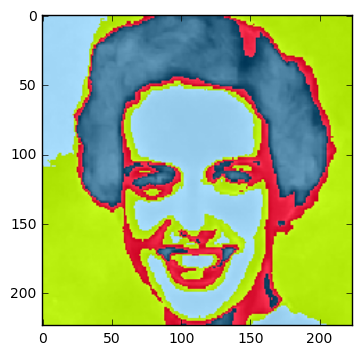

In [15]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [16]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [17]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [18]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 224, 224, 64)


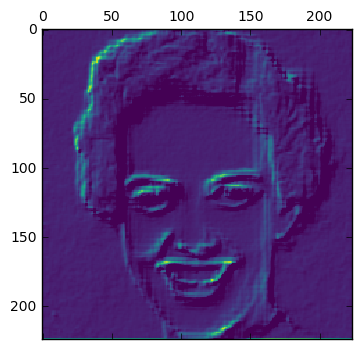

In [19]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

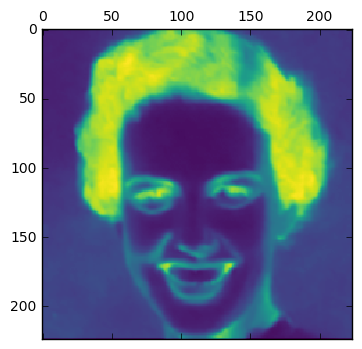

In [24]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))
/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/axis.py:1015: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/axis.py:1025: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

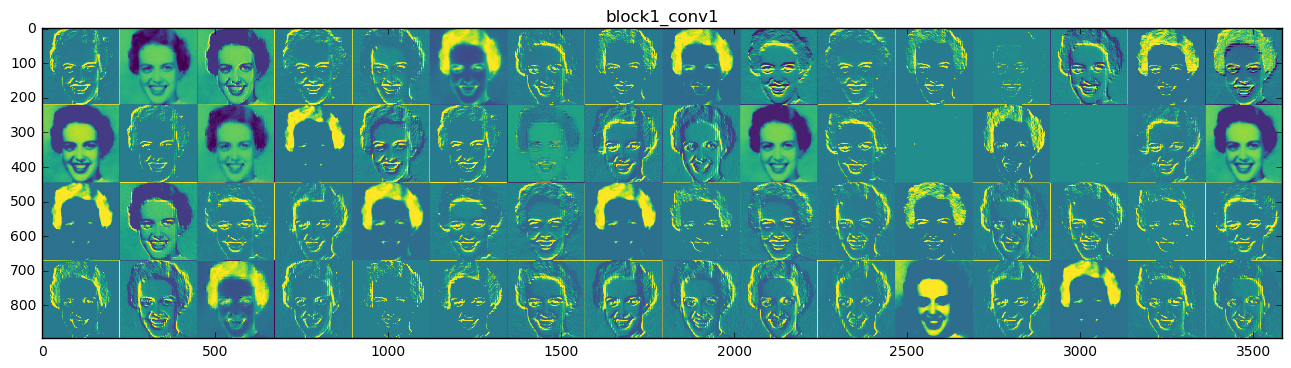

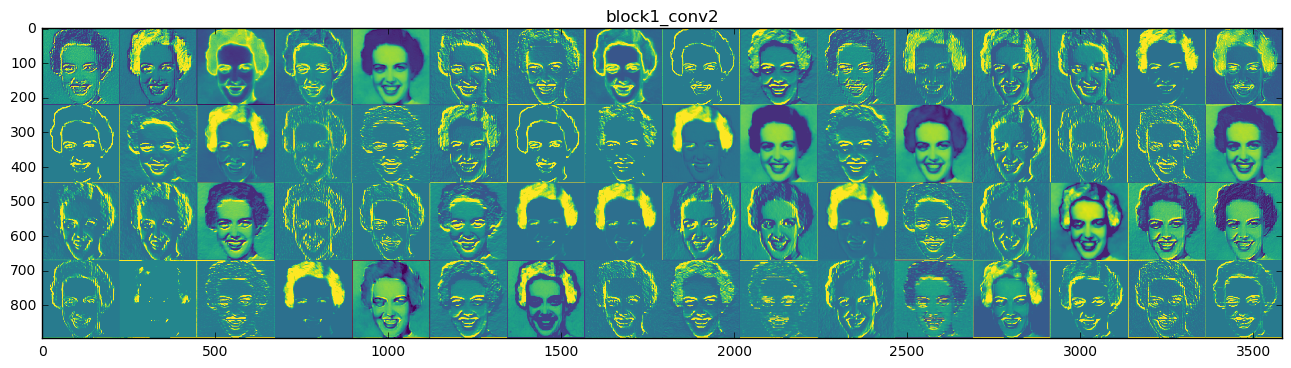

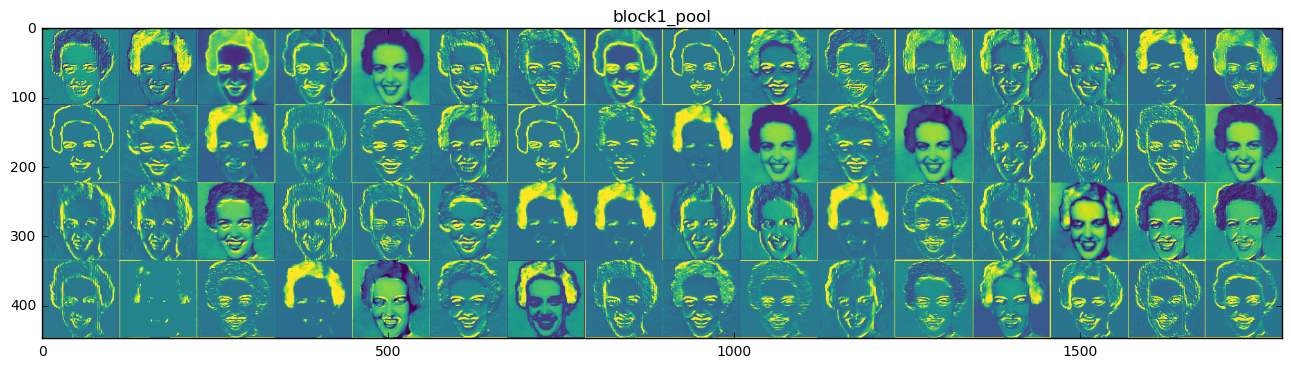

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [27]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.savefig('test.png')
plt.show()

# Visualizing convnet filters


In [28]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [29]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

In [30]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [34]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 224, 224, 3))])

In [35]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [37]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [42]:
def generate_pattern(layer_name, filter_index, size=224):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

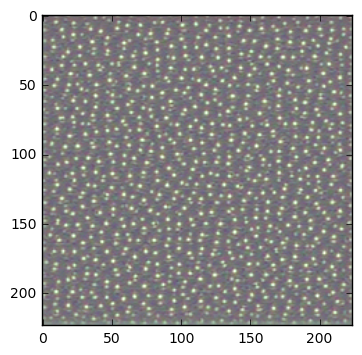

In [43]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

In [45]:
# for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
for layer_name in ['block1_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.savefig('filters.png')
#     plt.show()

# Visualizing heatmaps of class activation


In [84]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '../data/yearbook/train_inceptionv3/1910/000644.png'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

print(x.shape)

(1, 224, 224, 3)


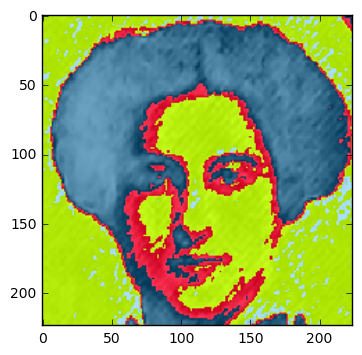

In [85]:
import matplotlib.pyplot as plt

plt.imshow(x[0])
plt.show()

In [86]:
# from keras.applications.vgg16 import VGG16

# K.clear_session()

# # Note that we are including the densely-connected classifier on top;
# # all previous times, we were discarding it.
# model = VGG16(weights='imagenet')

In [87]:
preds = model.predict(x)
print(preds.shape)
# print('Predicted:', decode_predictions(preds, top=3)[0])

(1, 104)


In [88]:
mapping = {0: '1905', 1: '1906', 2: '1908', 3: '1909', 4: '1910', 5: '1911', 6: '1912', 7: '1913', 8: '1914', 9: '1915', 
           10: '1916', 11: '1919', 12: '1922', 13: '1923', 14: '1924', 15: '1925', 16: '1926', 17: '1927', 18: '1928', 
           19: '1929', 20: '1930', 21: '1931', 22: '1932', 23: '1933', 24: '1934', 25: '1935', 26: '1936', 27: '1937', 
           28: '1938', 29: '1939', 30: '1940', 31: '1941', 32: '1942', 33: '1943', 34: '1944', 35: '1945', 36: '1946', 
           37: '1947', 38: '1948', 39: '1949', 40: '1950', 41: '1951', 42: '1952', 43: '1953', 44: '1954', 45: '1955', 
           46: '1956', 47: '1957', 48: '1958', 49: '1959', 50: '1960', 51: '1961', 52: '1962', 53: '1963', 54: '1964', 
           55: '1965', 56: '1966', 57: '1967', 58: '1968', 59: '1969', 60: '1970', 61: '1971', 62: '1972', 63: '1973', 
           64: '1974', 65: '1975', 66: '1976', 67: '1977', 68: '1978', 69: '1979', 70: '1980', 71: '1981', 72: '1982', 
           73: '1983', 74: '1984', 75: '1985', 76: '1986', 77: '1987', 78: '1988', 79: '1989', 80: '1990', 81: '1991', 
           82: '1992', 83: '1993', 84: '1994', 85: '1995', 86: '1996', 87: '1997', 88: '1998', 89: '1999', 90: '2000', 
           91: '2001', 92: '2002', 93: '2003', 94: '2004', 95: '2005', 96: '2006', 97: '2007', 98: '2008', 99: '2009', 
           100: '2010', 101: '2011', 102: '2012', 103: '2013'}

In [89]:
np.argmax(preds[0])

5

In [90]:
mapping[np.argmax(preds[0])]

'1911'

In [94]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 4]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

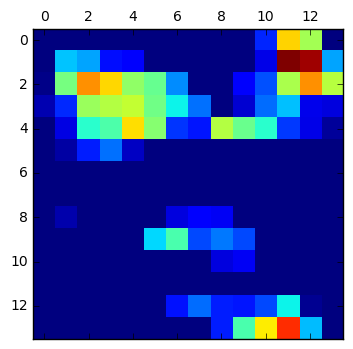

In [95]:

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [96]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('superimposed.jpg', superimposed_img)

True

In [22]:
import keras
keras.__version__
import keras.backend as K



In [23]:
def mean_L1_distance(y_true, y_pred):
    return K.mean(K.abs(K.argmax(y_pred,axis = -1) - K.argmax(y_true,axis = -1)), axis=-1)

In [24]:
train_dir = '../data/yearbook/train_VGG16/'
validation_dir = '../data/yearbook/valid_VGG16/'

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(171, 186, 3))

In [26]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 171, 186, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 171, 186, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 171, 186, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 85, 93, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 85, 93, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 85, 93, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 46, 128)       0         
__________

In [27]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(104, activation='softmax'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dense_4 (Dense)              (None, 104)               26728     
Total params: 18,018,472
Trainable params: 18,018,472
Non-trainable params: 0
_________________________________________________________________


In [29]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [30]:
conv_base.trainable = False

In [31]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [32]:
response_classes = ['1905', '1906', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1919',
                    '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933',
                    '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945',
                    '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
                    '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
                    '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
                    '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
                    '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
                    '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(171, 186),
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        classes=response_classes)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(171, 186),
        batch_size=128,
        classes=response_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr= 0.00005, decay=0.1),
              metrics=['acc', mean_L1_distance])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= 22840/128,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=22840/128)

Found 22840 images belonging to 104 classes.
Found 5009 images belonging to 104 classes.
Epoch 1/2
179/178 [==============================] - 1040s - loss: 4.3897 - acc: 0.0498 - mean_L1_distance: 19.4134 - val_loss: 4.7827 - val_acc: 0.0127 - val_mean_L1_distance: 15.3339
Epoch 2/2
179/178 [==============================] - 1005s - loss: 4.2167 - acc: 0.0774 - mean_L1_distance: 17.8212 - val_loss: 4.8495 - val_acc: 0.0082 - val_mean_L1_distance: 14.7050


In [35]:
history.history

{'acc': [0.049781085824799412, 0.077364273210123],
 'loss': [4.3899602375598379, 4.2165927992184402],
 'mean_L1_distance': [19.408406304728548, 17.814360770577935],
 'val_acc': [0.012729214883389709, 0.0081853558169700767],
 'val_loss': [4.7827180083459737, 4.8495323250725306],
 'val_mean_L1_distance': [15.333852590350721, 14.704969360826587]}

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r.', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig("train_val_acc.png")
plt.close()

plt.figure()

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig("train_val_loss.png")

plot_model(model, to_file="keras.png")

In [14]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 171, 186, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 171, 186, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 171, 186, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 85, 93, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 85, 93, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 85, 93, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 46, 128)       0         
__________

In [15]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr= 0.00001, decay=0.1),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= 22840/128,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=22840/128)

Epoch 1/3
179/178 [==============================] - 272s - loss: 4.0777 - acc: 0.0986 - val_loss: 4.7896 - val_acc: 0.0162
Epoch 2/3
179/178 [==============================] - 272s - loss: 4.0746 - acc: 0.0987 - val_loss: 4.7826 - val_acc: 0.0164
Epoch 3/3
179/178 [==============================] - 274s - loss: 4.0592 - acc: 0.0962 - val_loss: 4.7888 - val_acc: 0.0168


In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("train_val_acc.png")

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig("train_val_loss.png")
plot_model(model, to_file='keras.png')

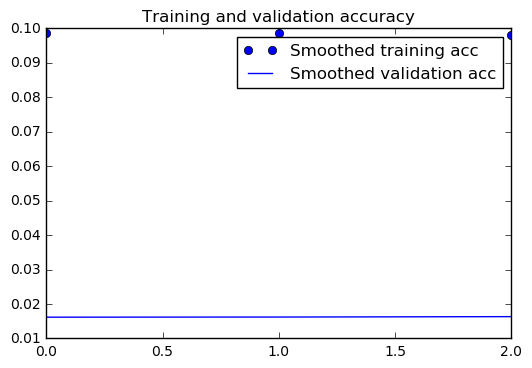

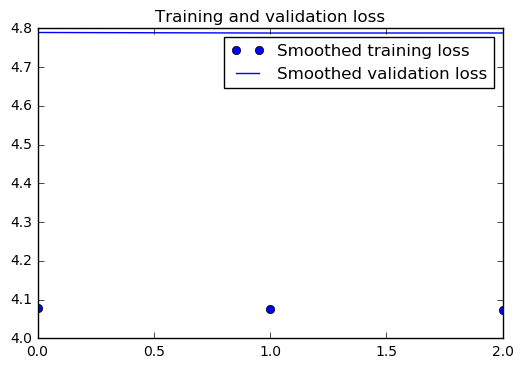

In [18]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
results_df = pd.read_csv('model_results.csv')

In [38]:
results_df

,Unnamed: 0,date,architecture,optimizer,loss,learning_rate,epochs,batch_size,train_acc,train_loss,val_acc,val_loss,model_name
0,0,2017-10-02_13:10,inceptionv3,rmsprop,categorical_crossentropy,0.001,1,128,[0.29811733803481855],[2.8345799118750148],[0.020163705331148991],[5.3213182008773368],inceptionv3_categorical_crossentropy_rmsprop_l...


In [25]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(171, 186, 3))

In [26]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 171, 186, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 171, 186, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 171, 186, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 85, 93, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 85, 93, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 85, 93, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 46, 128)       0         
__________

In [27]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(104, activation='softmax'))

In [28]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 36


In [29]:
conv_base.trainable = False

In [30]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [40]:

print('Number of trainable weight tensors '
      'before starting the fine-tuning step:', len(model.trainable_weights))

conv_base.trainable = True



set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('Number of trainable weight tensors '
  'during the fine-tuning step:', len(model.trainable_weights))

Number of trainable weight tensors before starting the fine-tuning step: 35
Number of trainable weight tensors during the fine-tuning step: 4


In [44]:
from keras.applications import xception

conv_base = xception.Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(171, 186, 3))

In [45]:
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 171, 186, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 85, 92, 32)    864         input_7[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 85, 92, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 85, 92, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [46]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(104, activation='softmax'))



print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))


conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))


conv_base.trainable = True

print('Number of trainable weight tensors '
      'before starting the fine-tuning step:', len(model.trainable_weights))


set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block11_sepconv1_act':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('Number of trainable weight tensors '
  'during the fine-tuning step:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158
This is the number of trainable weights after freezing the conv base: 4
Number of trainable weight tensors before starting the fine-tuning step: 158
Number of trainable weight tensors during the fine-tuning step: 47


In [58]:
from keras.applications import resnet50


conv_base = resnet50.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [59]:
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_10[0][0]                   
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_99 (Activation)       (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [60]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(104, activation='softmax'))



print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))


conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))


conv_base.trainable = True

print('Number of trainable weight tensors '
      'before starting the fine-tuning step:', len(model.trainable_weights))


set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'res4a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('Number of trainable weight tensors '
  'during the fine-tuning step:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216
This is the number of trainable weights after freezing the conv base: 4
Number of trainable weight tensors before starting the fine-tuning step: 216
Number of trainable weight tensors during the fine-tuning step: 120


In [81]:
results_df = pd.read_csv('model_results.csv')

In [82]:
results_df

,Unnamed: 0,date,architecture,optimizer,loss,learning_rate,epochs,batch_size,train_acc,train_loss,val_acc,val_loss,model_name


In [83]:
print(len(results_df.index))

0


In [84]:
results_df.loc[len(results_df.index)] = [1, 2, 3,4,5,6,7,8,9,10,11,12,13]

In [85]:
results_df

,Unnamed: 0,date,architecture,optimizer,loss,learning_rate,epochs,batch_size,train_acc,train_loss,val_acc,val_loss,model_name
0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0


In [16]:
mapping = {
 0: '1905', 1: '1906', 2: '1908', 3: '1909', 4: '1910', 5: '1911', 6: '1912', 7: '1913', 8: '1914', 9: '1915', 10: '1916',
 11: '1919', 12: '1922', 13: '1923', 14: '1924', 15: '1925', 16: '1926', 17: '1927', 18: '1928', 19: '1929', 20: '1930',
 21: '1931', 22: '1932', 23: '1933', 24: '1934', 25: '1935', 26: '1936', 27: '1937', 28: '1938', 29: '1939', 30: '1940',
 31: '1941', 32: '1942', 33: '1943', 34: '1944', 35: '1945', 36: '1946', 37: '1947', 38: '1948', 39: '1949', 40: '1950',
 41: '1951', 42: '1952', 43: '1953', 44: '1954', 45: '1955', 46: '1956', 47: '1957', 48: '1958', 49: '1959', 50: '1960',
 51: '1961', 52: '1962', 53: '1963', 54: '1964', 55: '1965', 56: '1966', 57: '1967', 58: '1968', 59: '1969', 60: '1970',
 61: '1971', 62: '1972', 63: '1973', 64: '1974', 65: '1975', 66: '1976', 67: '1977', 68: '1978', 69: '1979', 70: '1980',
 71: '1981', 72: '1982', 73: '1983', 74: '1984', 75: '1985', 76: '1986', 77: '1987', 78: '1988', 79: '1989', 80: '1990',
 81: '1991', 82: '1992', 83: '1993', 84: '1994', 85: '1995', 86: '1996', 87: '1997', 88: '1998', 89: '1999', 90: '2000',
 91: '2001', 92: '2002', 93: '2003', 94: '2004', 95: '2005', 96: '2006', 97: '2007', 98: '2008', 99: '2009', 100: '2010',
 101: '2011', 102: '2012', 103: '2013'}

In [21]:
int(mapping[i for i in [61, 65, 67]])

SyntaxError: invalid syntax (<ipython-input-21-6154a1e85dc1>, line 1)

2+2 

In [18]:
2+2

4